In [1]:
!python -m pip install multiple-hypothesis-testing

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    # import glob; print(glob.glob('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis/*'))
    import sys
    sys.path.append('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis')
except:
    pass

In [3]:
from Higher_Criticism import Higher_Criticism
higher_criticism = Higher_Criticism(use_import=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

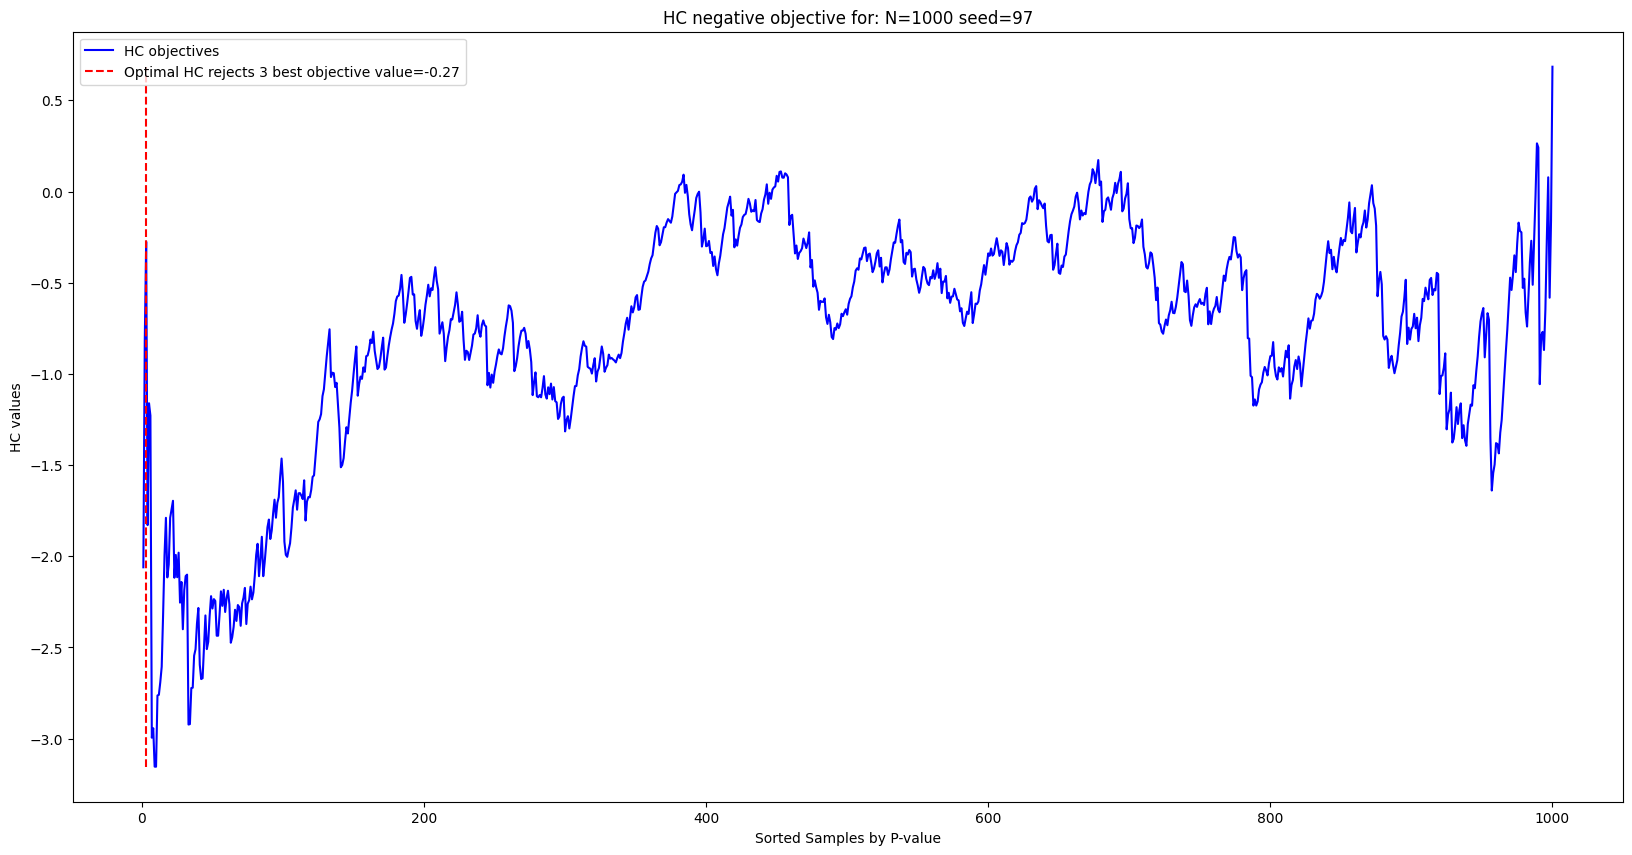

100%|██████████| 1000/1000 [00:01<00:00, 656.32it/s]


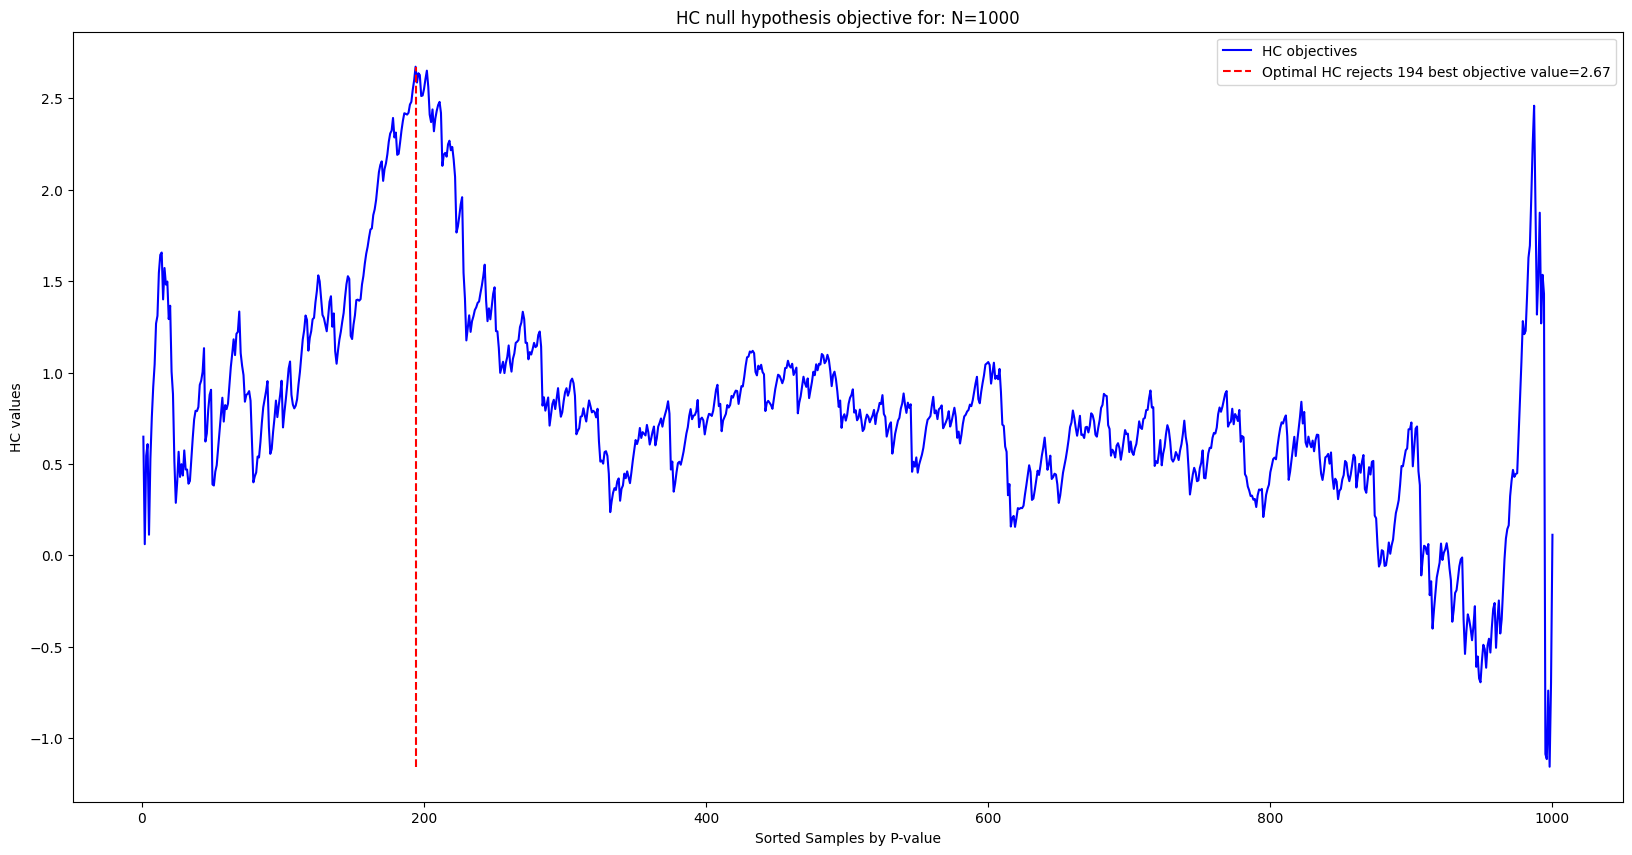

In [4]:


best_objectives, nums_rejected = higher_criticism.null_hypothesis(N = 1000, monte_carlo=1000)
